# Tutorial of Creating OpenGeoSys Mesh with Inclined Borehole Heat Exchangers

This tutorial is made to illustrate the procedure of creating an OGS mesh file with inclined Borehole Heat Exchangers (BHEs) in it. Such mesh uses prism elements for the soil part, and line elements for the BHEs. However, in this tutorial of inclined BHEs, a layer of hexagonal shape prism mesh is created around each BHE for optimal accuracy (Diersch et al. 2011) and all other parts of the geometry consist of tetrahedron mesh element to avoid complexity in mesh creation. The produced mesh file is made explicitly for the HEAT_TRANSPORT_BHE module in OGS and will NOT work with other modules. For better understanding, an image of 1D inclined BHEs is presented.

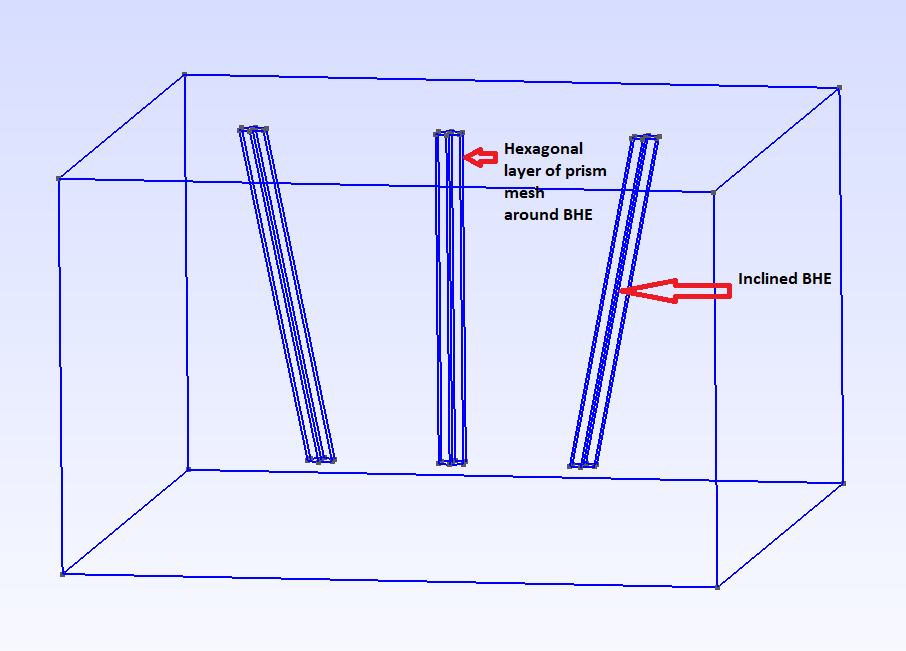




First, External packages have  been imported and gmsh is initialized.

In [1]:
import os
import sys
from pathlib import Path

import gmsh

gmsh.initialize()

The geometry is a 3D structure that has 3 boreholes (2 inclined and 1 vertical) in it. Similar to the previous tutorial of BHEs, the first step is to create the surface 1 with all the necessary points which regulate the borehole locations, as well as the mesh size. Now we define the basic geometry of the BHEs, as well as the element sizes around them. 

In [ ]:
# environment variable for output path
out_dir = os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out")
if not Path(out_dir).exists():
    Path(out_dir).mkdir(parents=True)

exe_dir = os.environ.get("OGS_BINARY_DIR")

# mesh file name
bhe_mesh_file_name = "inclined_bhe_mesh_file"

# geometry parameters
width = 20
length = 20
depth = 12
bhe_depth = depth - 2

# element sizes
bhe_radius = 0.07
alpha = 6.134  # see Diersch et al. 2011 Part 2
delta = (
    alpha * bhe_radius
)  # meshsize at BHE and distance of the surrounding optimal mesh points
elem_size = 0.5

In this step, we are going to create the top surface using the python interface of Gmsh.
To create a point with the built-in CAD kernel, the Python API function gmsh.model.geo.addPoint() is used.
The first 3 arguments are the point coordinates (x, y, z)
The next (optional) argument is the target mesh size close to the point
The last (optional) argument is the point tag (a strictly positive integer that uniquely identifies the point).
Here, we have assigned 4 boundary points

In [ ]:
# cube surface
gmsh.model.geo.addPoint(-width / 2.0, 0.0, 0.0, elem_size, 1)
gmsh.model.geo.addPoint(width / 2.0, 0.0, 0.0, elem_size, 2)
gmsh.model.geo.addPoint(width / 2.0, length, 0.0, elem_size, 3)
gmsh.model.geo.addPoint(-width / 2.0, length, 0.0, elem_size, 4)

4

Next, the API function gmsh.model.geo.addLine is used to create straight-line segments with the built-in kernel follows the same conventions: 
the first 2 arguments are point tags (the start and end points of the line), and the last (optional) is the line tag. Note that curve tags are separate from point tags. 
Hence we can reuse tag '1' for our first curve. And as a general rule, elementary entity tags in Gmsh have to be unique per geometrical dimension.

In [ ]:
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)

4

Next, a curve loop has been defined by using the ordered list of 4 connected lines. 
The API function to create curve loops takes a list of integers as the first argument, and the curve loop tag (which must be unique amongst curve loops) as the second (optional) argument.

In [ ]:
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)

1

In this step, the structure of the geometry is added. 
In order to create the structure, bottom surface and other surrounding sufaces have been created using similar method to the top surface. 
Hence, four points of the bottom surface have been added. 
Later, all necessary lines have been added to build the 3D geometry. 
Next, 5 curve loops (4 surroundings and 1 bottom) have been defined and corresponding plane surface is added using the API function gmsh.model.geo.addPlaneSurface. 

In [ ]:
gmsh.model.geo.addPoint(-width / 2.0, 0.0, -depth, elem_size, 101)
gmsh.model.geo.addPoint(width / 2.0, 0.0, -depth, elem_size, 102)
gmsh.model.geo.addPoint(width / 2.0, length, -depth, elem_size, 103)
gmsh.model.geo.addPoint(-width / 2.0, length, -depth, elem_size, 104)

gmsh.model.geo.addLine(1, 101, 101)
gmsh.model.geo.addLine(2, 102, 102)
gmsh.model.geo.addLine(3, 103, 103)
gmsh.model.geo.addLine(4, 104, 104)
gmsh.model.geo.addLine(101, 102, 105)
gmsh.model.geo.addLine(102, 103, 106)
gmsh.model.geo.addLine(103, 104, 107)
gmsh.model.geo.addLine(104, 101, 108)


gmsh.model.geo.addCurveLoop([105, 106, 107, 108], 5)
gmsh.model.geo.addCurveLoop([2, 103, -106, -102], 6)
gmsh.model.geo.addCurveLoop([3, 104, -107, -103], 7)
gmsh.model.geo.addCurveLoop([4, 101, -108, -104], 8)
gmsh.model.geo.addCurveLoop([1, 102, -105, -101], 9)

gmsh.model.geo.addPlaneSurface([5], 5)
gmsh.model.geo.addPlaneSurface([6], 6)
gmsh.model.geo.addPlaneSurface([7], 7)
gmsh.model.geo.addPlaneSurface([8], 8)
gmsh.model.geo.addPlaneSurface([9], 9)

9

Now, 3 BHE surfaces have been created using parameters such as BHE coordinates, delta. The BHE node is surrounded by the 6 additional nodes in hexagonal shape which will create better mesh for optimal accuracy (Diersch et al. 2011 Part 2 DOI:10.1016/j.cageo.2010.08.002). 

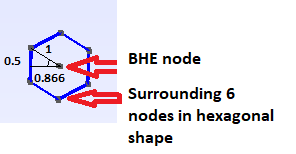
For each BHE node, 6 additional nodes and 6 corresponding line are added.
After that, a curve loop is created using 6 lines.
Then, the BHE surface is defined using that curve loop.
Following the same method, BHE surface 2 and 3 have been created.

In [ ]:
# BHE surfaces 1
gmsh.model.geo.addPoint(-6, 10, 0, delta, 5)
gmsh.model.geo.addPoint(-6, 10 - delta, 0, delta, 6)
gmsh.model.geo.addPoint(-6, 10 + delta, 0, delta, 7)
gmsh.model.geo.addPoint(-6 + 0.866 * delta, 10 + 0.5 * delta, 0, delta, 8)
gmsh.model.geo.addPoint(-6 - 0.866 * delta, 10 + 0.5 * delta, 0, delta, 9)
gmsh.model.geo.addPoint(-6 + 0.866 * delta, 10 - 0.5 * delta, 0, delta, 10)
gmsh.model.geo.addPoint(-6 - 0.866 * delta, 10 - 0.5 * delta, 0, delta, 11)

gmsh.model.geo.addLine(7, 8, 5)
gmsh.model.geo.addLine(8, 10, 6)
gmsh.model.geo.addLine(10, 6, 7)
gmsh.model.geo.addLine(6, 11, 8)
gmsh.model.geo.addLine(11, 9, 9)
gmsh.model.geo.addLine(9, 7, 10)

gmsh.model.geo.addCurveLoop([5, 6, 7, 8, 9, 10], 2)
gmsh.model.geo.addPlaneSurface([2], 2)

# BHE surfaces 2
gmsh.model.geo.addPoint(6, 10, 0, delta, 12)
gmsh.model.geo.addPoint(6, 10 - delta, 0, delta, 13)
gmsh.model.geo.addPoint(6, 10 + delta, 0, delta, 14)
gmsh.model.geo.addPoint(6 + 0.866 * delta, 10 + 0.5 * delta, 0, delta, 15)
gmsh.model.geo.addPoint(6 - 0.866 * delta, 10 + 0.5 * delta, 0, delta, 16)
gmsh.model.geo.addPoint(6 + 0.866 * delta, 10 - 0.5 * delta, 0, delta, 17)
gmsh.model.geo.addPoint(6 - 0.866 * delta, 10 - 0.5 * delta, 0, delta, 18)

gmsh.model.geo.addLine(14, 15, 11)
gmsh.model.geo.addLine(15, 17, 12)
gmsh.model.geo.addLine(17, 13, 13)
gmsh.model.geo.addLine(13, 18, 14)
gmsh.model.geo.addLine(18, 16, 15)
gmsh.model.geo.addLine(16, 14, 16)

gmsh.model.geo.addCurveLoop([11, 12, 13, 14, 15, 16], 3)
gmsh.model.geo.addPlaneSurface([3], 3)

# BHE surfaces 3
gmsh.model.geo.addPoint(0, 10, 0, delta, 19)
gmsh.model.geo.addPoint(0, 10 - delta, 0, delta, 20)
gmsh.model.geo.addPoint(0, 10 + delta, 0, delta, 21)
gmsh.model.geo.addPoint(0 + 0.866 * delta, 10 + 0.5 * delta, 0, delta, 22)
gmsh.model.geo.addPoint(0 - 0.866 * delta, 10 + 0.5 * delta, 0, delta, 23)
gmsh.model.geo.addPoint(0 + 0.866 * delta, 10 - 0.5 * delta, 0, delta, 24)
gmsh.model.geo.addPoint(0 - 0.866 * delta, 10 - 0.5 * delta, 0, delta, 25)

gmsh.model.geo.addLine(21, 22, 17)
gmsh.model.geo.addLine(22, 24, 18)
gmsh.model.geo.addLine(24, 20, 19)
gmsh.model.geo.addLine(20, 25, 20)
gmsh.model.geo.addLine(25, 23, 21)
gmsh.model.geo.addLine(23, 21, 22)

gmsh.model.geo.addCurveLoop([17, 18, 19, 20, 21, 22], 4)
gmsh.model.geo.addPlaneSurface([4], 4)
gmsh.model.geo.synchronize()

The 'gmsh.model.geo.extrude' command extrudes BHE surface 1, 2 and 3 along the z axis and automatically creates a new volume (as well as all the needed points, curves and surfaces). 
The function takes a vector of (dim, tag) pairs as input as well as the translation vector, and returns a vector of (dim, tag) pairs as output. 
For the BHE 1 and 2 in translational vector, x-cordinate is set to 2 and -2 respectively in order to create inclined BHE along x-direction. 
As a result, the end point of BHEs will be deflected by 2 units along (+) and (-) x-direction. 

The 2D mesh extrusion is done with the same 'extrude()' function, but by specifying element 'Layers' (Here, one layer each with 10 subdivisions). 
The number of elements for each layer and the (end) height of each layer are specified in two vectors. 
The last (optional) argument for the extrude() function specifies whether the extruded mesh should be recombined or not. 
In this case, it is 'True' since we want to recombine and produce prism mesh elements.

Later, BHE points 5, 12 and 19 have been extruded in the same way to create line elements (Lr, Ll and Lm) which represent BHEs.

In [ ]:
P = gmsh.model.geo.extrude([(2, 2)], 2, 0, -10, [10], [1], True)  # BHE surface 1
Q = gmsh.model.geo.extrude([(2, 3)], -2, 0, -10, [10], [1], True)  # BHE surface 2
R = gmsh.model.geo.extrude([(2, 4)], 0, 0, -10, [10], [1], True)  # BHE surface 3

Lr = gmsh.model.geo.extrude([(0, 5)], 2, 0, -10, [10], [1], True)  # BHE 1
Ll = gmsh.model.geo.extrude([(0, 12)], -2, 0, -10, [10], [1], True)  # BHE 2
Lm = gmsh.model.geo.extrude([(0, 19)], 0, 0, -10, [10], [1], True)  # BHE 3

gmsh.model.geo.synchronize()

Finally, geometry surface 1 is created by combining curve loop 1, 2, 3 and 4. 
Here, 2, 3, 4 are BHE curve loops and 1 is geometry curve loop. 
After that, 6 surfaces of geometry and 21 surfaces from 3 BHE hexagonal object is combined to create a surface loop. 
Later, volume is added to the surface loop using API function gmsh.model.geo.addVolume.
Before creating mesh, gmsh.model.geo.synchronize is used to synchronize the CAD entities with the Gmsh model, which will create the relevant Gmsh data structures.

In [ ]:
gmsh.model.geo.addPlaneSurface([1, 2, 3, 4], 1)

sl = gmsh.model.geo.addSurfaceLoop(
    [
        1,
        5,
        6,
        7,
        8,
        9,
        204,
        183,
        187,
        191,
        195,
        199,
        203,
        140,
        119,
        123,
        127,
        131,
        135,
        139,
        172,
        151,
        155,
        159,
        163,
        167,
        171,
    ]
)
v = gmsh.model.geo.addVolume([sl])

gmsh.model.geo.synchronize()

Later 'gmsh.model.addPhysicalGroup' command used to group elementary geometrical entities to define material properties. 
Gmsh will export in output files only mesh elements that belong to at least one physical group. 
Physical groups are also identified by tags, i.e. stricly positive integers, that should be unique per dimension (0D, 1D, 2D or 3D).
Here, BHE 1, 2 and 3 are tagged by 2, 3, 4 physical group respectively.

In [ ]:
gmsh.model.addPhysicalGroup(3, [P[1][1], Q[1][1], R[1][1], v], 1)
gmsh.model.addPhysicalGroup(1, [Lr[1][1]], 2)
gmsh.model.addPhysicalGroup(1, [Ll[1][1]], 3)
gmsh.model.addPhysicalGroup(1, [Lm[1][1]], 4)

4

Meshes generated with Gmsh must be converted to VTU file format later. Currently, the only supported Gmsh format is 2.2

In [ ]:
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)

Then We can then generate a 3D mesh and save it to disk

In [ ]:
gmsh.model.mesh.generate(3)

gmsh.model.mesh.removeDuplicateNodes()

gmsh.write(f"{out_dir}/{bhe_mesh_file_name}.msh")

Launch the GUI to see the results. Later gmsh.finalize() will be called when done using GMSH Python API

In [ ]:
if "-nopopup" not in sys.argv:
    gmsh.fltk.run()


gmsh.finalize()

If everything runs well, you will see the following mesh with incline BHEs.

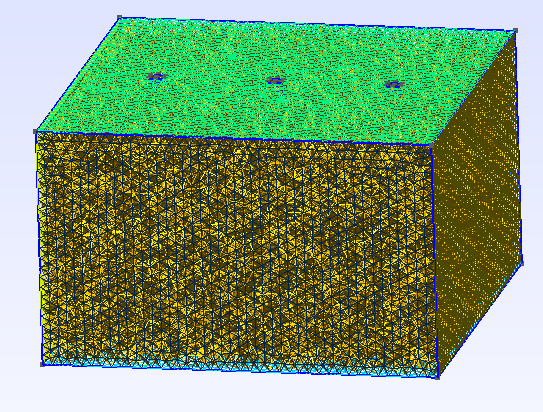


2D version will look like this.
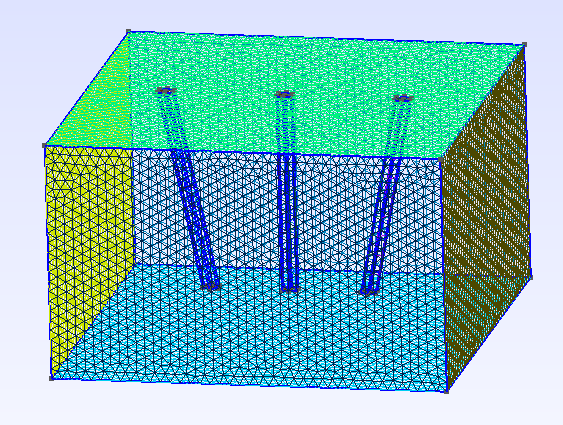

Now checking whether the Gmsh format mesh file is properly created. If not give an error message.

In [ ]:
check_file = Path(f"{out_dir}/{bhe_mesh_file_name}.msh").is_file()
if check_file:
    print("Creation of BHE mesh in Gmsh format was successful.")
else:
    print("Error! Gmsh file is not properly created in the BHE meshing tutorial.")

Creation of BHE mesh in Gmsh format was successful.


Finally, the mesh file which has been created using the python interface of Gmsh, will be converted to OGS mesh, in particular to VTU file format. Please, add ogs.exe to the directory of this example file to run GMSH2OGS or give the full path of your ogs executable. Here, option -v (--validation) validate the mesh and shows crucial information of mesh. Option -i takes gmsh input file name as string and -o is output file name as string as well.

In [ ]:
!GMSH2OGS -i {out_dir}/{bhe_mesh_file_name}.msh -o {out_dir}/{bhe_mesh_file_name}.vtu -v

[2023-11-24 20:26:53.970] [ogs] [info] Reading _out/inclined_bhe_mesh_file.msh.
[2023-11-24 20:26:58.706] [ogs] [info] 	... finished.
[2023-11-24 20:26:58.707] [ogs] [info] Nr. Nodes: 34959.
[2023-11-24 20:26:58.707] [ogs] [info] Nr. Elements: 191308.
[2023-11-24 20:26:58.719] [ogs] [info] Time for reading: 4.738397 seconds.
[2023-11-24 20:26:58.719] [ogs] [info] Read 34959 nodes and 191308 elements.
[2023-11-24 20:26:58.719] [ogs] [info] Please check your mesh carefully!
[2023-11-24 20:26:58.719] [ogs] [info] Degenerated or redundant mesh elements can cause OGS to stop or misbehave.
[2023-11-24 20:26:58.719] [ogs] [info] Use the -e option to delete redundant line elements.
[2023-11-24 20:26:58.721] [ogs] [info] Axis aligned bounding box: 	x [-10, 10) (extent 20)
	y [0, 20) (extent 20)
	z [-12, 4.94066e-324) (extent 12)
[2023-11-24 20:26:58.749] [ogs] [info] Edge length: [0.136446, 1.05802]
[2023-11-24 20:26:58.754] [ogs] [info] Number of elements in the mesh:
[2023-11-24 20:26:58.754]

The above conversion tool also shows that there exist line, tetrahedrons, pyramids and prism elements.The number of lines, tetrahedrons, pyramids  and prism element is respectively 30, 190918, 180 and 180 with no error.

In [ ]:
check_file = Path(f"{out_dir}/{bhe_mesh_file_name}.vtu").is_file()
if check_file:
    print("Conversion of mesh file from Gmsh to VTU format was successful.")
else:
    print(
        "Error! Gmsh file is not properly converted to VTU format in the BHE meshing tutorial."
    )

Conversion of mesh file from Gmsh to VTU format was successful.
